## Chapter 4. 전통 퀀트 투자 전략

퀀트 투자는 데이터 기반 (Data-Driven) 전략이라고 할 수 있다.<br>
전통 퀀트 방법론에 대해 살펴보고 
+ 평균 회귀 전략
+ 듀얼 모멘텀 전략을 구현하기 위한 절대 및 상대 모멘텀 투자 전략
+ 가치 투자 전략을 이용한 '마법 공식'

을 소개한다.

퀀트는 정량적(quantitative) 방법론을 기반으로 투자 의사를 결정하는 것이며, 정량적 방법론이란 모든 것을 수치화하는 것을 의미한다.
<br>
사용하는 데이터에 따라
+ 주가를 사용해 기술 지표를 만들고 이를 투자에 활용하는 '기술 지표 투자 전략'
+ 기업 재무제표를 사용하는 '가치 투자 전략'

이렇게 두 가지로 크게 나눌 수 있다. <br>
특히, 기술 지표를 활용한 투자 전략은 퀀트에서 가장 많이 사용하는 전략이며 주관적인 접근을 배제하고 주가 데이터로 만든 지표에만 의존해 투자 의사결정을 내리는 것인데, 사용하는 지표에는 주식시장에 대한 트레이더의 철학이 담겨있다고도 볼 수 있다.

쉬운 예로, '올라가는 주식이 계속 오른다'라고 믿는 트레이더들은 모멘텀 지표를 활용하는 전략을 선호할 것이다. 반면, '올라간 주식은 반드시 내려온다 (혹은 평균으로 회귀한다)'는 주가나 수익률의 **평균 회귀** 특성을 믿는 트레이더들은 평균 회귀 지표를 선호할 것이다.

이러한 지표 중 자주 사용하는 것은
+ 이동 평균선 (Moving Average)
+ 상대 강도 지수 (Relative Strength Index)
+ 스토캐스틱 오실레이터 (Stochastic Oscillator)

등이며 주식 시장을 바라보는 트레이더의 시각에 따라 사용되는 지표도 다르다. 따라서, 시장을 바라보는 자신만의 시각을 세우는 것이 우선이다.<br>
기술 지표를 활용한 퀀트 투자 전략 구현에서 관건은 주가 데이터를 활용해 기술 지표를 만드는 것이며, 해당 지표들로 신호를 발생시켜 종목을 매매하고 전략의 수익률이나 승률 등을 살펴볼 것이다.

가치 투자 전략은 당기순이익, 영업이익, 영업이익률, 매출액, 부채비율, PER, PBR, PSR, PCR, ROE, ROA 등 기업의 가치 판단에 기준이 되는 재무제표 데이터를 기초로 한다. 만약 자신이 CEO의 능력을 보고 투자하는 가치 투자자라고 한다면, 이 데이터를 정량화해 사용할 수도 있을 것이다. 예를 들어, CEO 출신 대학의 랭킹별로 점수를 매기고 연령이나 직군별로 정량화해 점수를 주는 식으로 말이다. 가치 투자 전략으로는 조엘 그린블라트가 만든 자본 수익률과 이익 수익률 지표를 활용한 '마법 공식'을 만들어 볼 것이다.

### 4.2. 평균 회귀 전략

여기서 살펴볼 평균 회귀 전략은 과거부터 특정 종목의 가격이 일정 평균값으로 수렴하는 경향을 관찰하여 미래 시점에도 일정 값으로 수렴할 것이라는 아이디어를 이용한 전략이다. 따라서 매매 전략 역시 주가의 평균가격을 계산해 일정 범위를 유지하느냐 이탈하느냐를 기준으로 낮으면 앞으로 주가가 상승할 것으로 기대해 주식을 매수하고, 높으면 앞으로 주가가 하락할 것으로 예상해 주식을 매도하는 규칙을 설정할 것이다. 그 범위의 기준은 익히 잘 알려진 **볼린저 밴드**기법을 활용할 것이다.

In [4]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np

df = fdr.DataReader('SPY', start='1993-01-28')

In [5]:
# describe() 내장 함수를 이용해 데이터셋의 분포, 중심, 경향 분산 및 형태를 요약하는 통계 정보 확인
df.describe()

,Close,Open,High,Low,Volume,Change
count,7045.000000,7045.000000,7045.000000,7045.000000,7.045000e+03,7045.000000
mean,143.889641,143.892935,144.742627,142.944152,8.444203e+07,0.000371
std,71.337321,71.335701,71.629566,71.011196,9.677348e+07,0.011925
min,43.410000,43.340000,43.530000,42.810000,0.000000e+00,-0.109400
25%,99.850000,99.820000,100.760000,98.780000,7.610000e+06,-0.004500
50%,127.230000,127.220000,128.020000,126.310000,5.803000e+07,0.000600
75%,182.880000,182.840000,183.560000,181.710000,1.211200e+08,0.005800
max,370.170000,370.880000,371.050000,367.720000,8.715500e+08,0.145200


종가 정보를 이용할 것이므로 종가만을 추출하여 새로운 DF를 만든다.

In [6]:
price_df = df[['Close']].copy()
price_df.head()

# copy() 함수를 사용하는 이요는 원본 데이터가 변경되면 연쇄적으로 데이터가 변경될 수 있기 때문에 원본 데이터가 훼손되는 것을 방지하고자 사용하는 것이다.

,Close
Date,
1993-02-01,44.25
1993-02-02,44.34
1993-02-03,44.81
1993-02-04,45.00
1993-02-05,44.97


다음으로 볼린저 밴드를 만들 것이다.

+ 상단 밴드 = 중간 밴드 + 2 * 20일 이동 평균 표준편차
+ 중간 밴드 = 20일 이동 평균선
+ 하단 밴드 = 중간 밴드 - 2 * 20일 이동 평균 표준편차

In [7]:
price_df['center'] = price_df['Close'].rolling(window=20).mean()
price_df.iloc[18:25]

,Close,center
Date,,
1993-02-26,44.41,NaN
1993-03-01,44.28,44.2910
1993-03-02,44.94,44.3255
1993-03-03,45.12,44.3645
1993-03-04,44.88,44.3680
1993-03-05,44.75,44.3555
1993-03-08,45.75,44.3945


In [9]:
# 상단 밴드와 하단 밴드를 만든다.
price_df['ub'] = price_df['center'] + 2 * price_df['Close'].rolling(window=20).std()
price_df['lb'] = price_df['center'] - 2 * price_df['Close'].rolling(window=20).std()

price_df.iloc[18:25]

,Close,center,ub,lb
Date,,,,
1993-02-26,44.41,NaN,NaN,NaN
1993-03-01,44.28,44.2910,45.409587,43.172413
1993-03-02,44.94,44.3255,45.480726,43.170274
1993-03-03,45.12,44.3645,45.573214,43.155786
1993-03-04,44.88,44.3680,45.582537,43.153463
1993-03-05,44.75,44.3555,45.547588,43.163412
1993-03-08,45.75,44.3945,45.715321,43.073679


위에서 작성한 코드를 통합하여 볼린저 밴드를 다시 사용할 수 있도록 함수로 작성하자.

In [28]:
def bollinger_band(price_df, n=20, sigma=2):
    
    bb = price_df.copy()
    bb['center'] = price_df['Close'].rolling(window=n).mean() # n일 이평선
    bb['ub'] = bb['center'] + (sigma * price_df['Close'].rolling(window=n).std()) # 상단 밴드
    bb['lb'] = bb['center'] - (sigma * price_df['Close'].rolling(window=n).std()) # 하단 밴드
    
    return bb

bollinger = bollinger_band(price_df)

In [29]:
base_date = '2009-01-02'
sample = bollinger.loc[base_date : ]
sample.head()

,Close,center,ub,lb
Date,,,,
2009-01-02,92.96,88.7495,92.776292,84.722708
2009-01-05,92.85,89.1270,93.207413,85.046587
2009-01-06,93.47,89.4040,93.875681,84.932319
2009-01-07,90.67,89.3875,93.836764,84.938236
2009-01-08,91.04,89.4645,93.974846,84.954154


평균 회귀 전략에서 진입/청산 신호가 발생할 때 우리가 취하는 행동을 기록할 데이터프레임을 만들어보자. 앞으로 이러한 데이터프레임을 거래 장부(Trading Book)이라고 부른다.

In [30]:
book = sample[['Close']].copy()
book['trade'] = '' # 거래내역 칼럼
book.head()

,Close,trade
Date,,
2009-01-02,92.96,
2009-01-05,92.85,
2009-01-06,93.47,
2009-01-07,90.67,
2009-01-08,91.04,


In [31]:
# trade 칼럼을 새로 만들어주는 함수
def create_trade_book(sample):
    book = sample[['Close']].copy()
    book['trade'] = ''
    return (book)

### 거래 전략

In [52]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'Close'] > sample.loc[i, 'ub']: # 상단 밴드 이탈 시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'Close']: # 하단 밴드 이탈 시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'
            else:
                book.loc[i, 'trade'] = 'buy'
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'Close'] and sample.loc[i, 'Close'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy' # 매수 상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안 함
    
    return (book)

```for loop```과 날짜별로 ```if-else```조건문을 검사하여 진입 조건에 맞으면 매수하고 청산 조건에 맞으면 매도한다.

In [55]:
book = tradings(sample, book)
book.tail(10)

,Close,trade
Date,,
2020-12-01,366.02,buy
2020-12-02,366.79,buy
2020-12-03,366.69,buy
2020-12-04,369.85,buy
2020-12-07,369.09,buy
2020-12-08,370.17,buy
2020-12-09,366.85,buy
2020-12-10,366.73,buy
2020-12-11,366.30,buy


거래내역을 기록했으니 마지막으로 수익률을 계산해보자. ```returns()```함수를 구현해 트레이딩 book에 적혀있는 거래내역대로 진입/청산 일자에 따른 매수/매도 금액을 바탕으로 수익률을 계산한다.
그다음에는 계산된 수익률로 종목의 누적 수익률을 계산한다.

### 전략 수익률

In [56]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        # long 진입
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':
            buy = book.loc[i, 'Close']
            print('진입일 : ', i, 'long 진입가격', buy)
        # long 청산
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':
            sell = book.loc[i, 'Close']
            rtn = (sell-buy) / buy + 1 # 손익계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ', i, 'long 진입가격 : ', buy, ' | long 청산가격 : ', sell, ' | return : ', round(rtn, 4))
        if book.loc[i, 'trade'] == '': # 제로 포지션
            buy = 0.0
            sell = 0.0
            
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn # 누적수익률 계산
        book.loc[i, 'acc return'] = acc_rtn
    
    print('Accumulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [57]:
print(returns(book))

진입일 :  2009-01-20 00:00:00 long 진입가격 80.57
청산일 :  2009-05-04 00:00:00 long 진입가격 :  80.57  | long 청산가격 :  90.88  | return :  1.128
진입일 :  2009-06-22 00:00:00 long 진입가격 89.28
청산일 :  2009-08-21 00:00:00 long 진입가격 :  89.28  | long 청산가격 :  102.97  | return :  1.1533
진입일 :  2010-01-22 00:00:00 long 진입가격 109.21
청산일 :  2010-04-05 00:00:00 long 진입가격 :  109.21  | long 청산가격 :  118.76  | return :  1.0874
진입일 :  2010-05-04 00:00:00 long 진입가격 117.52
청산일 :  2010-10-13 00:00:00 long 진입가격 :  117.52  | long 청산가격 :  117.92  | return :  1.0034
진입일 :  2011-03-10 00:00:00 long 진입가격 129.94
청산일 :  2011-04-26 00:00:00 long 진입가격 :  129.94  | long 청산가격 :  134.79  | return :  1.0373
진입일 :  2011-05-23 00:00:00 long 진입가격 132.06
청산일 :  2011-06-30 00:00:00 long 진입가격 :  132.06  | long 청산가격 :  131.97  | return :  0.9993
진입일 :  2011-08-02 00:00:00 long 진입가격 125.49
청산일 :  2012-02-03 00:00:00 long 진입가격 :  125.49  | long 청산가격 :  134.54  | return :  1.0721
진입일 :  2012-04-10 00:00:00 long 진입가격 135.9
청산일 :  2012-07-03 00:00:0

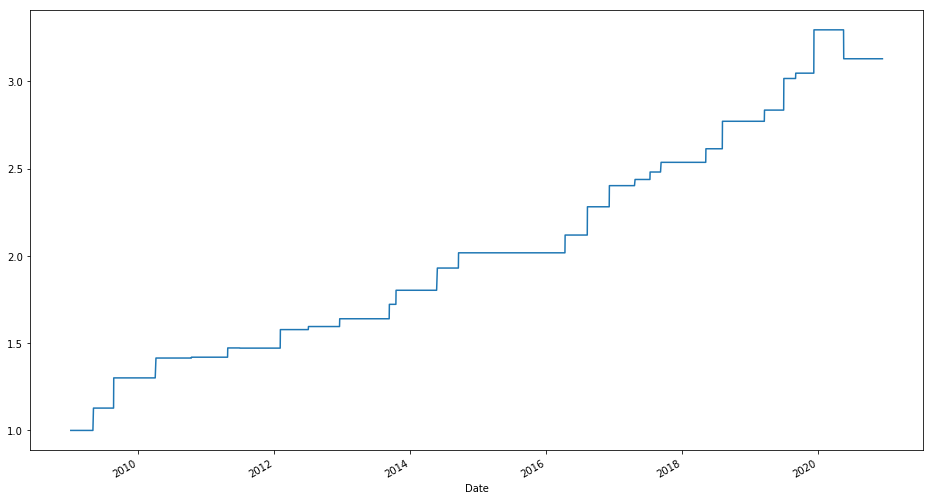

In [60]:
import matplotlib.pylab as plt
book['acc return'].plot(figsize=(16, 9))